# Load Library

In [1]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from model_utils import train_torch_model, test_torch_model, port_mlp_to_ch, port_ch_to_mlp, proxy_train_mlp
from data_utils import oneHotCatVars
from whitebox_attack import neuron_output, make_neuron_output_data, roc_curve_plot, get_LOMIA_case_1_correct_examples, Top10CorrNeurons, wb_corr_attacks
from disparate_vulnerability_utils import get_accuracy, get_indices_by_conditions, subgroup_vulnerability_distance_vector, subgroup_vulnerability_distance, get_subgroup_disparity, plot_subgroup_disparity, improved_subgroup_attack, get_subgroup_disparity_baseline, get_top_dist_indices
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import tabulate
# import utils

/Users/ehsanulkabir/miniconda/envs/tabular/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [69]:
subgroup_col_name = 'RAC1P'
split_ratio_first_subgroup = 0.5

sampling_condition_dict_list = [
    {
        'condition': lambda x: x[subgroup_col_name] < 2,
        'sample_size': round(split_ratio_first_subgroup * 100000),
    },
    {
        'condition': lambda x: x[subgroup_col_name] == 3,
        'sample_size': round(split_ratio_first_subgroup * 100000),
    },
]

# ds = data_utils.CensusWrapper(
#             filter_prop="none", ratio=float(0.5), split="all", name="Census19")

ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict_list=sampling_condition_dict_list, sensitive_column='DEAR')
(x_tr, y_tr), (x_te, y_te), cols = ds.load_data()
X_train = pd.DataFrame(x_tr, columns=cols)
y_tr_onehot = ds.ds.y_enc.transform(y_tr).toarray()


# ds.ds.filenameroot = ds.ds.name
ds.ds.filenameroot = ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"

# Load and Train Target Model

In [70]:
save_model = True

try:
    clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model.pkl')
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    clf = model_utils.get_model(max_iter=500)
    clf.fit(X_train, y_tr_onehot)

    if save_model:
        model_utils.save_model(clf, f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_target_model.pkl')

# Train Multiple Target Models with various hyperparameters to have various degrees of overfitting


In [37]:
hidden_layer_size_tuples = [(32* i, 16 *i, 8*i) for i in range(1, 11)]
clfs = {}
load_models = True
save_models = False

for i, hidden_layer_size_tuple in enumerate(hidden_layer_size_tuples):
    # Train Target Model
    if load_models:
        clf = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_target_model_overfit_level_{i}.pkl')
    else:
        clf = model_utils.get_model(hidden_layer_sizes=hidden_layer_size_tuple, max_iter=500)
        clf.fit(X_train, y_tr_onehot)

    # Save Target Model
    if save_models:
        model_utils.save_model(clf, f'<PATH_TO_MODEL>/{ds.ds.name}_target_model_overfit_level_{i}.pkl')

    # Evaluate Target Model
    y_pred = clf.predict(X_train)

    train_acc = 100 * clf.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
    test_acc = 100 * clf.score(x_te, ds.ds.y_enc.transform(y_te).toarray())

    print(f"Overfit Level: {i}, Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%")

    clfs[i] = clf

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 0, Train Accuracy: 85.92%, Test Accuracy: 84.48%
Overfit Level: 1, Train Accuracy: 87.67%, Test Accuracy: 83.76%


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 2, Train Accuracy: 89.13%, Test Accuracy: 83.26%
Overfit Level: 3, Train Accuracy: 89.25%, Test Accuracy: 82.88%


X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 4, Train Accuracy: 89.76%, Test Accuracy: 82.95%


X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 5, Train Accuracy: 90.49%, Test Accuracy: 82.83%


X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 6, Train Accuracy: 90.17%, Test Accuracy: 82.89%


X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 7, Train Accuracy: 91.01%, Test Accuracy: 82.60%


X does not have valid feature names, but MLPClassifier was fitted with feature names


Overfit Level: 8, Train Accuracy: 90.84%, Test Accuracy: 82.14%
Overfit Level: 9, Train Accuracy: 91.36%, Test Accuracy: 82.00%


X does not have valid feature names, but MLPClassifier was fitted with feature names


In [38]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_tr_onehot, cv=5)

# Test Target Model

In [16]:
# train_acc = 100 * clf.score(x_tr, y_tr.ravel())
# test_acc = 100 * clf.score(x_te, y_te.ravel())
train_acc = 100 * clf.score(X_train, ds.ds.y_enc.transform(y_tr).toarray())
test_acc = 100 * clf.score(x_te, ds.ds.y_enc.transform(y_te).toarray())
if True:
    print("Classifier: Train acc %.2f , Test acc %.2f\n" %
            (train_acc, test_acc))

Classifier: Train acc 90.50 , Test acc 86.72



X does not have valid feature names, but MLPClassifier was fitted with feature names


In [66]:
# calculate classification report
from sklearn.metrics import classification_report
y_pred = clf.predict(x_te)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_te
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     41350
           1       0.59      0.44      0.50      8650

    accuracy                           0.85     50000
   macro avg       0.74      0.69      0.71     50000
weighted avg       0.84      0.85      0.84     50000



X does not have valid feature names, but MLPClassifier was fitted with feature names


# Calculate Permutation Importance

In [16]:
X_te = pd.DataFrame(x_te, columns=cols)

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_te, ds.ds.y_enc.transform(y_te).toarray(),
                           n_repeats=30,
                           random_state=0)

In [7]:
r_train = permutation_importance(clf, X_train, ds.ds.y_enc.transform(y_tr).toarray(),
                            n_repeats=30,
                            random_state=0)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0 or True:
        print(f"{cols[i]} "
              f"{r.importances_mean[i]:.8f}"
              f" +/- {r.importances_std[i]:.8f}")

# Convert to PyTorch Model

In [6]:
target_model = port_mlp_to_ch(clf)

In [7]:
y_te_onehot = ds.ds.y_enc.transform(y_te).toarray()
test_acc = test_torch_model(target_model, x_te, y_te_onehot)
print("Classifier: Test acc %.2f\n" % (test_acc))

tensor([[0.0148, 0.3586, 0.6266],
        [0.0130, 0.6868, 0.3003],
        [0.0454, 0.4080, 0.5466],
        ...,
        [0.0451, 0.2831, 0.6719],
        [0.0011, 0.0353, 0.9636],
        [0.0257, 0.6634, 0.3108]], device='mps:0', grad_fn=<SoftmaxBackward0>)
Classifier: Test acc 0.60



In [7]:
clf = model_utils.get_model(max_iter=500)
clf.partial_fit(X_train, y_tr_onehot, classes=np.unique(y_tr))
clf = port_ch_to_mlp(target_model, clf)

In [8]:
clf = proxy_train_mlp(x_tr, y_tr_onehot)

Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.


# LOMIA Attack

In [71]:
attack_dataset = model_utils.LOMIA_attack(clf, X_train, y_tr, ds.ds.meta)

100%|██████████| 50000/50000 [01:27<00:00, 570.46it/s]


In [72]:
attack_df = pd.concat(attack_dataset)
attack_df[ds.ds.meta['y_column']] = attack_df[ds.ds.meta['y_column']].apply(lambda x: ds.ds.meta['y_values'][x])

In [73]:
attack_df.to_csv(f'<PATH_TO_DATASET>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}.csv')

# Load Attack Data

In [74]:
attack_df = pd.read_csv(f'<PATH_TO_DATASET>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}.csv')
attack_df.index = attack_df['Unnamed: 0']
attack_df.index.name = None
attack_df = attack_df.drop('Unnamed: 0', axis=1)

In [75]:
# Split the DataFrame into input and output variables
X_attack = attack_df.drop([f'{ds.ds.meta["sensitive_column"]}_{val}' for val in ds.ds.meta['sensitive_values']], axis=1) 
X_attack = oneHotCatVars(X_attack, ds.ds.meta['y_column'])
y_attack = attack_df[[ f'{ds.ds.meta["sensitive_column"]}_{ds.ds.meta["sensitive_positive"]}']]
# y_attack_onehot, att_enc = onehot(y_attack.to_numpy())
y_attack_onehot = ds.ds.sensitive_enc.transform(y_attack.to_numpy()).toarray()

# Train Attack Model

In [76]:
attack_clf = model_utils.get_model(max_iter=500)

In [77]:
attack_clf.fit(X_attack, y_attack_onehot)
model_utils.save_model(attack_clf, f'<PATH_TO_MODEL>/{ds.ds.filenameroot}_LOMIA_attack_{ds.ds.meta["sensitive_column"]}_model.pkl')

In [91]:
all_sensitive_columns = ['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']

aucs, recalls = {}, {}

for sensitive_column in all_sensitive_columns:
    temp_ds = data_utils.CensusWrapper(
            filter_prop="none", ratio=float(0.5), split="all", name="Census19", sampling_condition_dict_list=sampling_condition_dict_list, sensitive_column=sensitive_column)
    temp_ds.ds.filenameroot = temp_ds.ds.name + f"_{subgroup_col_name}_{round(100*split_ratio_first_subgroup)}_{round(100*(1-split_ratio_first_subgroup))}_minority_categorized"
    X, y = temp_ds.ds.get_attack_df()

    X = X.astype(float)

    subgroup_columns = ['RAC1P']

    attack_clf = model_utils.load_model(f'<PATH_TO_MODEL>/{temp_ds.ds.filenameroot}_LOMIA_attack_{temp_ds.ds.meta["sensitive_column"]}_model.pkl')

    subgroup_disparity_dict = get_subgroup_disparity(temp_ds, subgroup_columns, attack_clf, X, y, metric='auc')

    aucs[sensitive_column] = subgroup_disparity_dict['RAC1P']['asrs']

    subgroup_disparity_dict = get_subgroup_disparity(temp_ds, subgroup_columns, attack_clf, X, y, metric='recall')

    recalls[sensitive_column] = subgroup_disparity_dict['RAC1P']['asrs']


# Permutation Importance vs LOMIA Attack Performance on Different Subgroups

In [87]:
def get_perm_imp(r):
    result_mean, result_std = {}, {}
    # for i in r.importances_mean.argsort()[::-1]:
    for i in range(len(r.importances_mean)):
        # if r.importances_mean[i] - 2 * r.importances_std[i] > 0 or True:
        # print(i)
        if cols[i] in all_sensitive_col_full_names:
            # print(f"{cols[i]} "
            #     f"{r.importances_mean[i]:.8f}"
            #     f" +/- {r.importances_std[i]:.8f}")
            result_mean[cols[i]] = r.importances_mean[i]
            result_std[cols[i]] = r.importances_std[i]

    return result_mean, result_std

all_sensitive_col_full_names = [f'{col}' for col in cols.to_numpy() if col.split('_')[0] in all_sensitive_columns + ['MAR']]

r_rac1ps = []

for i in range(2):
    rac1p_indices = get_indices_by_conditions(ds, X_train, {'RAC1P': i})
    r_rac1ps.append(permutation_importance(clf, X_train.loc[rac1p_indices,:] , ds.ds.y_enc.transform(y_tr[rac1p_indices.to_numpy()]).toarray(),
                            n_repeats=30,
                            random_state=0))
    
perm_imps_race = {
    i: get_perm_imp(r_rac1ps[i])[0] for i in range(2)
}
# perm_imps_race['all'] = get_perm_imp(r_train)[0]

In [88]:
perm_imps_race_df = pd.DataFrame(perm_imps_race)

# for col in ['MAR', 'DREM', 'DPHY', 'DEAR', 'DEYE']:
#     results_race_df.loc[col] = results_race_df.loc[f'{col}_1'] / results_race_df.loc[f'{col}_0']

    # results_race_df.loc[col] = results_race_df.loc[col] / results_race_df.loc[col]['all']

perm_imps_race_df

,0,1
MAR_0,0.008589,0.008940
MAR_1,0.007039,0.010989
DREM_0,0.000590,0.000470
DREM_1,0.001642,0.000964
DPHY_0,0.000863,0.000418
DPHY_1,0.002103,0.000856
DEAR_0,0.002086,0.000277
DEAR_1,0.003039,0.001106
DEYE_0,0.000477,0.000309
DEYE_1,0.001104,0.000575


In [93]:
aucs_df = pd.DataFrame(aucs, columns=['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']).T

aucs_df

,1,0
MAR,62.363871,58.172708
DEAR,47.718611,47.146419
DEYE,45.459531,50.725307
DREM,59.143246,55.248223
DPHY,55.521323,55.488861


In [94]:
recalls_df = pd.DataFrame(recalls, columns=['MAR', 'DEAR', 'DEYE', 'DREM', 'DPHY']).T
recalls_df

,1,0
MAR,48.687672,44.240932
DEAR,54.205607,48.114901
DEYE,54.028436,52.439024
DREM,69.433962,80.802792
DPHY,48.192771,58.853288


In [98]:
ds.ds.original_df['RAC1P'].value_counts()

RAC1P
1    50000
0    50000
Name: count, dtype: int64

In [103]:
for col in all_sensitive_columns:
    # subgroup_columns = ['RAC1P']
    for i in range(2):
        temp_df = ds.ds.original_df.copy()
        temp_df = temp_df[temp_df['RAC1P'] == i]
        print(temp_df[col].value_counts())

MAR
0    27491
1    22509
Name: count, dtype: int64
MAR
0    31099
1    18901
Name: count, dtype: int64
DEAR
0    48886
1     1114
Name: count, dtype: int64
DEAR
0    49556
1      444
Name: count, dtype: int64
DEYE
0    49336
1      664
Name: count, dtype: int64
DEYE
0    49576
1      424
Name: count, dtype: int64
DREM
0    48887
1     1113
Name: count, dtype: int64
DREM
0    49466
1      534
Name: count, dtype: int64
DPHY
0    48823
1     1177
Name: count, dtype: int64
DPHY
0    49460
1      540
Name: count, dtype: int64


In [78]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)

X_tensor = torch.from_numpy(X.to_numpy()).float().to(model_utils.device)

In [ ]:
y_pred = attack_clf.predict(X)
y_pred = np.argmax(y_pred, axis=1)
fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=ds.ds.meta['sensitive_positive'])

roc_curve_plot(fpr, tpr)

In [80]:
subgroup_columns = ['SEX', 'RAC1P']


subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, attack_clf, X, y, metric='auc')
# plot_subgroup_disparity(subgroup_disparity_dict)

In [81]:
subgroup_disparity_dict

{'SEX': {'asrs': {1: 45.45629578564919, 0: 46.880302575550324},
  'dists': {1: 0.47555274716480317, 0: 0.5249773781651957}},
 'RAC1P': {'asrs': {1: 47.71861138515065, 0: 47.14641926893228},
  'dists': {1: 0.3721013198833526, 0: 0.36511937389200066}}}

In [ ]:
acc = 100 * attack_clf.score(X, ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray())
if True:
    print(f"Attack accuracy: {acc}")

In [ ]:
attack_model = model_utils.port_mlp_to_ch(attack_clf)

In [ ]:
predictions = attack_model(X_tensor)
# calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(X_tensor)):
        if predictions[i].argmax().item() == y.iloc[i].astype(int):
            correct += 1
        total += 1

print(f'Accuracy of the network on the {len(X_tensor)} test images: {100 * correct / total} %')

# Model Inversion with Full Records

In [8]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)
y_onehot = ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

In [12]:
load_model = False
save_model = False

if load_model:
    inv_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_inverse_model.pkl')
else:

    inv_clfs = {}

    for test_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

        # inv_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(60, 50, 40, 30, 20, 10))
        # pca_clf.fit(x_tr, y_tr)
        inv_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
        inv_clfs[test_size] = inv_clf

        acc = 100 * inv_clf.score(x_te, y_te)
        print(f'Inverse accuracy with test size {test_size}: {acc}')

    if save_model:
        model_utils.save_model(inv_clfs, f'<PATH_TO_MODEL>/{ds.ds.name}_inverse_model.pkl')

The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1681628961578/work/aten/src/ATen/mps/MPSFallback.mm:12.)
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
X has feature names, but MLPClassifier was fitted without feature names


Inverse accuracy with test size 0.5: 80.11223786551147


Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
X has feature names, but MLPClassifier was fitted without feature names


Inverse accuracy with test size 0.6: 80.20346213799327


Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
X has feature names, but MLPClassifier was fitted without feature names


Inverse accuracy with test size 0.7: 80.14767932489451


Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
X has feature names, but MLPClassifier was fitted without feature names


Inverse accuracy with test size 0.8: 80.25473787841496
Inverse accuracy with test size 0.9: 80.27675983153749


Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
X has feature names, but MLPClassifier was fitted without feature names


In [13]:
inv_names = []
inv_aucs = []

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

    inv_clf = inv_clfs[test_size]
    
    # calculate auc
    y_pred = inv_clf.predict_proba(x_te)
    auc = roc_auc_score(y_te, y_pred)
    inv_names.append(f'Inverse-{round((1-test_size)*100)}%')
    inv_aucs.append(auc*100)
    print(f'AUC with test size {test_size}: {auc}')

X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names


AUC with test size 0.9: 0.6781803649833609
AUC with test size 0.8: 0.7067886557938723
AUC with test size 0.7: 0.6349196025788865
AUC with test size 0.6: 0.6502157232068793
AUC with test size 0.5: 0.6738628827857591


In [14]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=42)

inv_clf = inv_clfs[test_size]
subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, inv_clf, x_te, y_te, metric='auc')

X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names
X has feature names, but MLPClassifier was fitted without feature names


In [15]:
subgroup_disparity_dict

{'sex': {'asrs': {'female': 67.787787006559, 'male': 68.25819129634048},
  'dists': {'female': 0.46091587952206253, 'male': 0.46132652413598085}},
 'race': {'asrs': {'white': 67.83822944792823,
   'other': 63.72492836676217,
   'black': 65.22246835986468},
  'dists': {'white': 0.5049655543241308,
   'other': 0.4823537204992204,
   'black': 0.5550439121607077}},
 'relig': {'asrs': {'catholic': 66.1844343192983,
   'protestant': 69.85981177565084,
   'none': 63.58577814409718},
  'dists': {'catholic': 0.42173846127528336,
   'protestant': 0.5497922965933532,
   'none': 0.30830465067547735}}}

# Grad Approach

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Step 1: Prepare the dataset
# Assuming you have already loaded and preprocessed the GSS dataset
X_train_for_grad, X_test_for_grad, y_train_for_grad, y_test_for_grad = torch.tensor(x_tr, dtype=torch.float32, requires_grad=True), torch.tensor(x_te, dtype=torch.float32, requires_grad=True), torch.tensor(y_tr, dtype=torch.float32, requires_grad=True), torch.tensor(y_te, dtype=torch.float32, requires_grad=True)

# Step 2: Create a custom dataset
class GradAttDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = torch.Tensor(self.features[index])
        y = torch.Tensor([self.labels[index]])
        return x, y

train_dataset = GradAttDataset(X_train_for_grad, y_train_for_grad)
test_dataset = GradAttDataset(X_test_for_grad, y_test_for_grad)

# Step 8: Train the model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [68]:
all_sensitive_columns = ['default', 'DEAR', 'DEYE', 'DREM', 'DPHY']

In [69]:
def check_if_grad_stored():
    # check if the following list of files exist
    # if they do, then we have already stored the gradients
    # if not, then we need to store the gradients
    filenames = [f'grads/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy' for sens_col in all_sensitive_columns]
    return all([os.path.exists(filename) for filename in filenames])

if not check_if_grad_stored():
    for i, sens_col in enumerate(all_sensitive_columns):
        meta = data_utils.CensusWrapper(name='Census19', sensitive_column=sens_col, preload=False).ds.meta
        sens_indices = [cols.get_loc(f'{meta["sensitive_column"]}_{val}') for val in meta["sensitive_values"]]
        sens_attrs = []
        scores = []
        orig_grads = []
        grads_after_flip = []
        y_trues = []
        
        target_model = port_mlp_to_ch(clf)
        optim = torch.optim.Adam(target_model.parameters(), lr=0.001)
        # for batch in tqdm(train_loader):
        for idx, batch in enumerate(train_loader):
            # if idx > 100:
            #     break
            optim.zero_grad()
            # batch = next(iter(train_loader))
            x, y = batch
            x, y = x.to('mps'), y.to('mps')
            y_pred = target_model(x)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(y_pred, y.long().reshape(-1))
            # loss = nn.CrossEntropyLoss()(y_pred, y.long())
            loss.backward()
            grad = [p.grad.clone().detach().cpu().numpy().reshape(-1) for p in target_model.parameters()]
            grad = np.concatenate(grad)
            orig_grads.append(grad)

            optim.zero_grad()
            x_np = x.clone().detach().cpu().numpy()
            # x_np[0,55:57] = 1 - x_np[0,55:57]
            x_np[0, sens_indices] = 1 - x_np[0, sens_indices]
            x_clone = torch.tensor(x_np, requires_grad=True).to('mps')
            y_pred2 = target_model(x_clone)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(y_pred2, y.long().reshape(-1))
            loss.backward()
            grad2 = [p.grad.clone().detach().cpu().numpy().reshape(-1) for p in target_model.parameters()]
            grad2 = np.concatenate(grad2)
            grads_after_flip.append(grad2)

            # if x_np[0,55] == 1:
            if x_np[0, sens_indices[0]] == 1:
                sens_attr = 0
                # score = np.linalg.norm(grad) - np.linalg.norm(grad2)
                score = np.linalg.norm(grad - grad2)
            else:
                sens_attr = 1
                # score = np.linalg.norm(grad2) - np.linalg.norm(grad)
                score = np.linalg.norm(grad2 - grad)

            sens_attrs.append(sens_attr)
            scores.append(score)

        orig_grads = np.array(orig_grads)
        grads_after_flip = np.array(grads_after_flip)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy', orig_grads)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy', grads_after_flip)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy', sens_attrs)
        np.save(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy', scores)

In [70]:
original_aucs = {}

for i, sens_col in enumerate(all_sensitive_columns):
    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')

    print(f'For {sens_col}')
    auc = roc_auc_score(sens_attrs, scores)
    original_aucs[sens_col] = auc
    print(f'AUC: {auc}')

For default
AUC: 0.6495558813286206
For DEAR
AUC: 0.4650313285202574
For DEYE
AUC: 0.5840841870900447
For DREM
AUC: 0.6673405102013038
For DPHY
AUC: 0.5508716428668948


In [71]:
auc_dict_sex = {
    'male': {},
    'female': {},
    'all': {},
}

for i, sens_col in enumerate(all_sensitive_columns):
    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')

    # print(f'For {sens_col}')
    # auc = roc_auc_score(sens_attrs, scores)
    auc_dict_sex['male'][sens_col] = roc_auc_score(sens_attrs[male_indices.to_numpy()], scores[male_indices.to_numpy()])
    auc_dict_sex['female'][sens_col] = roc_auc_score(sens_attrs[female_indices.to_numpy()], scores[female_indices.to_numpy()])

    # print(f'AUC: {auc}')
    auc_dict_sex['all'][sens_col] = original_aucs[sens_col]

In [74]:
auc_dict_race = { i: {} for i in range(2) }
auc_dict_race['all'] = {}

race_marginal_prior_dict = (100 * ds.ds.original_df['RAC1P'].value_counts() / len(ds.ds.original_df)).to_dict()

for i in range(2):
    auc_dict_race[i]['marginal prior'] = race_marginal_prior_dict[str(i)]
auc_dict_race['all']['marginal prior'] = 100

for i, sens_col in enumerate(all_sensitive_columns):
    orig_grads = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_orig_grads.npy')
    grads_after_flip = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_grads_after_flip.npy')
    sens_attrs = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_sens_attrs.npy')
    scores = np.load(f'<PATH_TO_GRADS>/{ds.ds.filenameroot}_{sens_col}_scores.npy')
    

    for idx in range(2):
        rac1p_indices = get_indices_by_conditions(ds, X_train, {'RAC1P': str(idx)})
        try:
            auc_dict_race[idx][sens_col] = roc_auc_score(sens_attrs[rac1p_indices.to_numpy()], scores[rac1p_indices.to_numpy()])
        except:
            auc_dict_race[idx][sens_col] = np.nan

    auc_dict_race['all'][sens_col] = original_aucs[sens_col]

In [17]:
all_sensitive_col_full_names = [f'{col}' for col in cols.to_numpy() if col.split('_')[0] in all_sensitive_columns + ['MAR']]

In [20]:
male_indices = get_indices_by_conditions(ds, X_train, {'SEX': 0})
female_indices = get_indices_by_conditions(ds, X_train, {'SEX': 1})

In [26]:
r_male = permutation_importance(clf, X_train.loc[male_indices,:] , ds.ds.y_enc.transform(y_tr[male_indices.to_numpy()]).toarray(),
                           n_repeats=30,
                           random_state=0)

In [27]:
r_female = permutation_importance(clf, X_train.loc[female_indices,:] , ds.ds.y_enc.transform(y_tr[female_indices.to_numpy()]).toarray(),
                           n_repeats=30,
                           random_state=0)

In [29]:
r_rac1ps = []

for i in range(2):
    rac1p_indices = get_indices_by_conditions(ds, X_train, {'RAC1P': str(i)})
    r_rac1ps.append(permutation_importance(clf, X_train.loc[rac1p_indices,:] , ds.ds.y_enc.transform(y_tr[rac1p_indices.to_numpy()]).toarray(),
                            n_repeats=30,
                            random_state=0))

In [30]:
def get_perm_imp(r):
    result_mean, result_std = {}, {}
    # for i in r.importances_mean.argsort()[::-1]:
    for i in range(len(r.importances_mean)):
        # if r.importances_mean[i] - 2 * r.importances_std[i] > 0 or True:
        # print(i)
        if cols[i] in all_sensitive_col_full_names:
            # print(f"{cols[i]} "
            #     f"{r.importances_mean[i]:.8f}"
            #     f" +/- {r.importances_std[i]:.8f}")
            result_mean[cols[i]] = r.importances_mean[i]
            result_std[cols[i]] = r.importances_std[i]

    return result_mean, result_std


In [31]:
results = {
    'male': get_perm_imp(r_male)[0],
    'female': get_perm_imp(r_female)[0],
    'all': get_perm_imp(r_train)[0],
}

In [33]:
results_race = {
    i: get_perm_imp(r_rac1ps[i])[0] for i in range(2)
}
results_race['all'] = get_perm_imp(r_train)[0]

In [75]:
results_sex_df = pd.DataFrame(results)
# for col in ['MAR', 'DREM', 'DPHY', 'DEAR', 'DEYE']:
#     results_sex_df.loc[col] = results_sex_df.loc[f'{col}_1'] / results_sex_df.loc[f'{col}_0']

    # results_sex_df.loc[col] = results_sex_df.loc[col] / results_sex_df.loc[col]['all']

results_sex_df

,male,female,all
MAR_0,0.016111,0.008089,0.012179
MAR_1,0.014000,0.007113,0.010555
DREM_0,0.001769,0.001008,0.001328
DREM_1,0.002538,0.001145,0.001857
DPHY_0,0.001077,0.000790,0.000925
DPHY_1,0.002344,0.001717,0.002009
DEAR_0,0.002284,0.000467,0.001397
DEAR_1,0.003987,0.000826,0.002379
DEYE_0,0.000577,0.000177,0.000325
DEYE_1,0.001511,0.000887,0.001200


In [76]:
pd.DataFrame(auc_dict_sex, index=['default', 'DREM', 'DPHY', 'DEAR', 'DEYE'])

,male,female,all
default,0.650452,0.648575,0.649556
DREM,0.676439,0.658132,0.667341
DPHY,0.539627,0.562294,0.550872
DEAR,0.461679,0.468535,0.465031
DEYE,0.573676,0.595514,0.584084


In [60]:
results_race_df = pd.DataFrame(results_race)

# for col in ['MAR', 'DREM', 'DPHY', 'DEAR', 'DEYE']:
#     results_race_df.loc[col] = results_race_df.loc[f'{col}_1'] / results_race_df.loc[f'{col}_0']

    # results_race_df.loc[col] = results_race_df.loc[col] / results_race_df.loc[col]['all']

results_race_df

,0,1,all
MAR_0,0.015299,0.008398,0.012179
MAR_1,0.011381,0.009522,0.010555
DREM_0,0.001551,0.001136,0.001328
DREM_1,0.002199,0.001479,0.001857
DPHY_0,0.001290,0.000597,0.000925
DPHY_1,0.002466,0.001710,0.002009
DEAR_0,0.002108,0.000715,0.001397
DEAR_1,0.003345,0.001466,0.002379
DEYE_0,0.000415,0.000313,0.000325
DEYE_1,0.001365,0.000917,0.001200


In [77]:
auc_race_df = pd.DataFrame(auc_dict_race, index=['marginal prior', 'default', 'DREM', 'DPHY', 'DEAR', 'DEYE'])
auc_race_df = auc_race_df.rename(index={'default': 'MAR'})
auc_race_df

,0,1,all
marginal prior,90.000000,10.000000,100.000000
MAR,0.650119,0.644419,0.649556
DREM,0.667973,0.661995,0.667341
DPHY,0.548765,0.570692,0.550872
DEAR,0.464299,0.471844,0.465031
DEYE,0.586810,0.554370,0.584084


# PCA Approach

In [4]:
X, y = ds.ds.get_attack_df()
# Convert X to float
X = X.astype(float)
y_onehot = ds.ds.sensitive_enc.transform(y.to_numpy().ravel().reshape(-1, 1)).toarray()

In [5]:
load_model = True
save_model = False

if load_model:
    pca_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/{ds.ds.name}_pca_model.pkl')
else:

    pca_clfs = {}

    pca_clfs['pca'] = {}

    for test_size in [0.5, 0.6, 0.7, 0.8, 0.9]:
        x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

        pca = PCA(n_components=2)
        pca.fit(x_tr)
        pca_clfs['pca'][test_size] = pca
        x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

        # inv_clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(60, 50, 40, 30, 20, 10))
        # inv_clf.fit(x_tr, y_tr)
        pca_clf = model_utils.proxy_train_mlp(x_tr.to_numpy(), y_tr, epochs=100)
        pca_clfs[test_size] = pca_clf

        acc = 100 * pca_clf.score(x_te, y_te)
        print(f'PCA accuracy with test size {test_size}: {acc}')

    if save_model:
        model_utils.save_model(pca_clfs, f'<PATH_TO_MODEL>/{ds.ds.name}_pca_model.pkl')

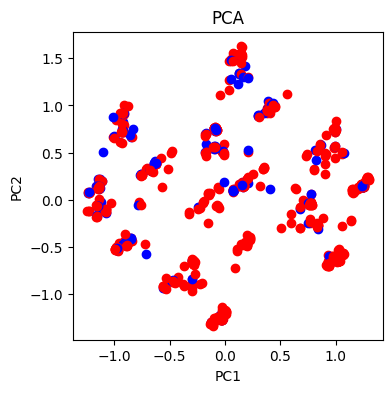

In [30]:
# plot the data in 2D
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

pca_clf = pca_clfs[test_size]
pca = pca_clfs['pca'][test_size]
x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

x_te = x_te.to_numpy()

# sample only 100 points from x_te and y_te to plot
x_te, y_te = map(lambda x: x[:1000], [x_te, y_te])

# y_te has values 0 or 1
# use y_te to get the color
colors = ['red', 'blue']
for i in range(len(x_te)):
    ax.scatter(x_te[i, 0], x_te[i, 1], color=colors[y_te[i].argmax()])
plt.show()


In [8]:
pca_names = []
pca_aucs = []

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_tr, x_te, y_tr, y_te = train_test_split(X, y_onehot, test_size=test_size, random_state=42)

    pca_clf = pca_clfs[test_size]
    pca = pca_clfs['pca'][test_size]

    x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])
    
    # calculate auc
    y_pred = pca_clf.predict_proba(x_te)
    auc = roc_auc_score(y_te, y_pred)
    pca_names.append(f'Inverse-{round((1-test_size)*100)}%')
    pca_aucs.append(auc*100)
    print(f'AUC with test size {test_size}: {auc}')

AUC with test size 0.9: 0.6882299137224867
AUC with test size 0.8: 0.6816837620807288
AUC with test size 0.7: 0.6872772697701737
AUC with test size 0.6: 0.6223830080585047
AUC with test size 0.5: 0.4436415919458482


In [24]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=42)

pca_clf = pca_clfs[test_size]
pca = pca_clfs['pca'][test_size]

x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

for col in subgroup_columns:
    values = ds.ds.unique_values_dict[col]
    subgroup_asrs = {}
    subgroup_dists = {}

    for val in values:
        if len(get_indices_by_conditions(ds, X, {col:val})) > 500:
            indices = get_indices_by_conditions(ds, x_te, {col:val})
            x_te_subgroup = x_te.loc[indices]
            y_te_subgroup = y_te.loc[indices]

            # calculate the correlation between x_te_subgroup features and the sensitive attribute y_te_subgroup
            corr = x_te_subgroup.corrwith(y_te_subgroup)

            print(f'Correlation between {col}={val} and y: \n {corr}')

            # subgroup_asrs[val] = get_accuracy(ds, {col:val}, neuron_clf, X_neuron, y, metric=metric)
            # subgroup_dists[val] = subgroup_vulnerability_distance(ds, {col:val}, X_neuron)

    # subgroup_disparity_dict[col] = {'asrs':subgroup_asrs, 'dists':subgroup_dists}



Correlation between sex=female and y: 
 0   -0.215873
1    0.173536
dtype: float64
Correlation between sex=male and y: 
 0   -0.247972
1    0.237983
dtype: float64
Correlation between race=white and y: 
 0   -0.214484
1    0.147567
dtype: float64
Correlation between race=other and y: 
 0   -0.227755
1    0.139988
dtype: float64
Correlation between race=black and y: 
 0   -0.295523
1    0.129385
dtype: float64
Correlation between relig=catholic and y: 
 0   -0.199335
1    0.092997
dtype: float64
Correlation between relig=protestant and y: 
 0   -0.208331
1    0.161940
dtype: float64
Correlation between relig=none and y: 
 0   -0.184526
1    0.064951
dtype: float64


In [6]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.9

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=42)

pca_clf = pca_clfs[test_size]
pca = pca_clfs['pca'][test_size]

x_tr, x_te = map(lambda x: pd.DataFrame(pca.transform(x), index=x.index), [x_tr, x_te])

subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, pca_clf, x_te, y_te, metric='auc')
# plot_subgroup_disparity(subgroup_disparity_dict, req_metrics=['asrs'])

In [7]:
subgroup_disparity_dict

{'sex': {'asrs': {'female': 67.09565537376565, 'male': 67.63211636734773},
  'dists': {'female': 0.40386482434639986, 'male': 0.4288420895965453}},
 'race': {'asrs': {'white': 68.60499680718284,
   'other': 68.1202105684014,
   'black': 70.7562722167843},
  'dists': {'white': 0.48478103092452246,
   'other': 0.4545342440718738,
   'black': 0.5227638039962372}},
 'relig': {'asrs': {'catholic': 66.1923596372757,
   'protestant': 70.54004924759978,
   'none': 62.97912350656776},
  'dists': {'catholic': 0.38058030033456874,
   'protestant': 0.4801861165946572,
   'none': 0.2762346338290832}}}

# Investigate Neuron Output

## From LOMIA Case 1

In [ ]:
X_attack_neuron = make_neuron_output_data(ds, X_attack, clf, y_columns)

In [ ]:
neuron_clf = model_utils.get_model(max_iter=500)

In [ ]:
neuron_clf.fit(X_attack_neuron, y_attack_onehot)

## From Original Data

In [15]:
X, y = ds.ds.get_attack_df()
X = X.astype(np.float32)
X_neuron = make_neuron_output_data(ds, X, clf, ds.ds.y_columns)



In [16]:
# subset features of X_neuron: 0:32 and 59:91
X_neuron = X_neuron.iloc[:,np.concatenate((np.arange(0,32), np.arange(59,91)))]

In [17]:
# find the indices of the data points that are correctly classified by the target model
# the prediction is a one-hot encoded vector, so we need to take the argmax to get the class label
df_x, df_y = ds.ds.df.drop([ds.ds.meta["y_column"], 'is_train'], axis=1), ds.ds.df[[ds.ds.meta["y_column"]]]
correct_indices = np.where(df_y.to_numpy().squeeze() != clf.predict(df_x).argmax(axis=1))[0]

In [ ]:
# get the data points that are correctly classified by the target model
# X, y, X_neuron = X.iloc[correct_indices, :], y.iloc[correct_indices], X_neuron.iloc[correct_indices, :]

In [18]:
# Split x and y into train and test
load_model = False
save_model = False

test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]
# test_sizes = [0.5]

if load_model:
    neuron_clfs = model_utils.load_model(f'<PATH_TO_MODEL>/neuron_clfs_{ds.ds.name}.pkl')
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_sizes[0], random_state=42)
    y_n_tr_onehot = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()
else:
    neuron_clfs={}

    hidden_layers = [64, 32, 16, 8, 4]

    lomia_case_1_indices = get_LOMIA_case_1_correct_examples(ds, X_train)
    # subset lomia_case_1_indices with the correct indices
    # lomia_case_1_indices = np.intersect1d(lomia_case_1_indices, correct_indices)
    if 'lomia_case_1_indices' in globals():
        x_n_tr, x_n_te, y_n_tr, y_n_te = X_neuron.iloc[lomia_case_1_indices], X_neuron.iloc[~np.isin(np.arange(len(X_neuron)), lomia_case_1_indices)], y[lomia_case_1_indices], y[~np.isin(np.arange(len(X_neuron)), lomia_case_1_indices)]

        x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)

        y_n_tr = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()
        # new_clf = model_utils.get_model(max_iter=2000)
        # # new_clf.set_params(hidden_layer_sizes=hidden_layers)
        # new_clf.set_params(alpha=0.1, solver='adam', activation='relu')
        # neuron_clfs['lomia_case_1'] = new_clf
        # neuron_clfs['lomia_case_1'].fit(x_n_tr, y_n_tr)
        neuron_clfs['lomia_case_1'] = proxy_train_mlp(x_n_tr.to_numpy(), y_n_tr, epochs=100)

    for test_size in test_sizes:
        x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)
        y_n_tr = ds.ds.sensitive_enc.transform(y_n_tr.to_numpy().ravel().reshape(-1,1)).toarray()

        x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)
        
        # new_clf = model_utils.get_model(max_iter=2000)
        # # new_clf.set_params(hidden_layer_sizes=hidden_layers)
        # new_clf.set_params(alpha=0.1, solver='adam', activation='relu')
        # neuron_clfs[test_size] = new_clf
        # neuron_clfs[test_size].fit(x_n_tr, y_n_tr)
        neuron_clfs[test_size] = proxy_train_mlp(x_n_tr.to_numpy(), y_n_tr, epochs=100)

    if save_model:
        model_utils.save_model(neuron_clfs, f'<PATH_TO_MODEL>/neuron_clfs_{ds.ds.name}.pkl')

The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1681628961578/work/aten/src/ATen/mps/MPSFallback.mm:12.)
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.


## Compare whitebox correlation attack and our attack

In [ ]:
top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_n_tr)
wb_preds = top_10_corr_neurons_model(torch.from_numpy(X_neuron).float()).detach().numpy()
# draw the ROC curve
y_wb_att = y.ravel().astype(np.float32)
fpr, tpr, thresholds = roc_curve(y_wb_att, wb_preds)

roc_curve_plot(fpr, tpr)

In [ ]:
our_preds = neuron_clfs[0.9].predict_proba(X_neuron)[:,1]

fpr, tpr, thresholds = roc_curve(y_wb_att, our_preds)

roc_curve_plot(fpr, tpr)

In [25]:
names = []
aucs = []
for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)
    top_10_corr_neurons_model = wb_corr_attacks(x_n_tr, y_n_tr)

    # wb_preds = top_10_corr_neurons_model(torch.from_numpy(X_neuron).float()).detach().numpy()
    wb_preds = top_10_corr_neurons_model(torch.from_numpy(x_n_te.to_numpy()).float()).detach().numpy()
    # draw the ROC curve
    y_wb_att = y_n_te.ravel().astype(np.float32)
    names.append(f'wb-corr-{round((1-test_size)*100)}%')
    aucs.append(roc_auc_score(y_wb_att, wb_preds))

for test_size in [0.9, 0.8, 0.7, 0.6, 0.5]:
    names.append(f'Ours-{round((1-test_size)*100)}%')
    x_n_tr, x_n_te, y_n_tr, y_n_te = train_test_split(X_neuron, y, test_size=test_size, random_state=42)

    x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)

    preds = neuron_clfs[test_size].predict_proba(x_n_te)[:,1]
    y_wb_att = y_n_te.ravel().astype(np.float32)
    aucs.append(roc_auc_score(y_wb_att, preds))

names.append('LOMIA')
lomia_preds = neuron_clfs['lomia_case_1'].predict_proba(x_n_te)[:,1]
aucs.append(roc_auc_score(y_wb_att, lomia_preds))

In [26]:
aucs

[0.678912491732209,
 0.6787099467979766,
 0.6842817359292275,
 0.686866137153973,
 0.6904934920184903,
 0.6755199624708518,
 0.3008810993060397,
 0.7012763456000798,
 0.6946487774554496,
 0.7127691987583913,
 0.6863817886028494]

In [ ]:
# plot bars with x ticks as names and y as aucs
# make the yticks vertical
plt.figure(figsize=(18,5))
plt.bar(names + inv_names, (np.array(aucs)*100).tolist() + inv_aucs)
plt.hlines(aucs[4]*100, -1, len(names + inv_names), linestyles='dashed')
# plt.ylim(60, 75)
plt.title('AUCs of different attacks')
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_aucs = (np.array(aucs[:-1])*100).tolist() + inv_aucs

# make a 2d numpy array of the aucs with shape (3, -1)
aucs_2d = np.array(all_aucs).reshape(3, -1)

In [ ]:
aucs_2d = pd.DataFrame(aucs_2d, columns=[f'{(i+1)*10}%' for i in range(5)], index=['WB-Corr', 'Ours', 'Inverse'])

In [ ]:
print(aucs_2d.round(2).to_latex(float_format="%.2f"))

In [ ]:
names + inv_names

## Subgroup Biased Neuron

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

subgroup_disparity_dict, subgroup_clfs = improved_subgroup_attack(ds, subgroup_columns, neuron_clfs[0.5], X_neuron, y, metric='accuracy')

print(subgroup_disparity_dict)

# plot_subgroup_disparity(subgroup_disparity_dict, subgroup_columns)

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

subgroup_disparity_dict, subgroup_clfs = improved_subgroup_attack(ds, subgroup_columns, neuron_clfs[0.5], X_neuron, y, metric='auc', dist_percentiles=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], epochs=100)

print(subgroup_disparity_dict)

In [ ]:
def highlight_max(row):
    # str_values = row[:2]
    # row = row[2:]
    max_val = row[2:-1].max()
    return ([r'\textbf{{{}}}'.format(val) if type(val) == float and val == max_val else val for val in row])

# round up float values to 2 decimal places
result = subgroup_disparity_dict.round(2)

# sort by 'Subgroup Name' column first and then by 'Marginal Prior' column
result = result.sort_values(by=['Subgroup Name', 'Marginal Prior'], ascending=[False, False])

# convert 'Margin Prior' column to string
result['Marginal Prior'] = result['Marginal Prior'].apply(lambda x: str(x))

result = result.apply(highlight_max, axis=1)

result = pd.DataFrame(result.to_list(), columns=subgroup_disparity_dict.columns)

# sort by 'Subgroup Name' column first and then by 'Marginal Prior' column
# result = result.sort_values(by=['Subgroup Name', 'Marginal Prior'], ascending=[False, False])

# put 'Marginal Prior' column as the 3rd column
cols = result.columns.tolist()
cols = cols[:2] + cols[-1:] + cols[2:-1]
result = result[cols]

In [ ]:
result

In [ ]:
from tabulate import tabulate

table = tabulate(result, headers='keys', tablefmt='latex_booktabs', showindex=False, floatfmt=".2f")

table = table.replace(r'\textbackslash{}', '\\')

table = table.replace(r'\{', '{').replace(r'\}', '}')

# print the LaTeX table
print(table)

## Most Discriminative Neuron

In [ ]:
def get_top_dist_indices(ds, conditions, X_neuron, dist_percentile=0.9):
    # normalize X_neuron first
    X_neuron_mean = X_neuron.mean(axis=0)
    X_neuron_std = X_neuron.std(axis=0)
    X_neuron = (X_neuron - X_neuron_mean) / X_neuron_std
    vec = subgroup_vulnerability_distance_vector(ds, conditions, X_neuron)
    # filter out the nan values
    nan_indices = np.argwhere(np.isnan(vec))
    vec = np.delete(vec, nan_indices)
    X_neuron = np.delete(X_neuron, nan_indices, axis=0)
    pos_vec = np.abs(vec)
    sorted_indices = np.argsort(-pos_vec)
    cum_norm = np.array([np.linalg.norm(vec[sorted_indices[:i]]) for i in range(1, len(sorted_indices)+1)])
    cum_norm_p = cum_norm / cum_norm[-1]
    idx = np.argmax(cum_norm_p > dist_percentile)
    top_indices = sorted_indices[:idx]

    return top_indices

In [ ]:
get_top_dist_indices(ds, {'sex':'male'}, x_n_tr)

In [ ]:
male_indices = get_indices_by_conditions(ds, x_n_tr, {'sex': 'male'})
female_indices = get_indices_by_conditions(ds, x_n_tr, {'sex': 'female'})

## Plot subgroup disparity

In [ ]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.5

x_n_tr, x_n_te, y_n_tr, y_n_te= train_test_split(X_neuron, y, test_size=test_size, random_state=42)
x_n_tr, x_n_te = data_utils.normalize(x_n_tr, x_n_te)
subgroup_disparity_dict = get_subgroup_disparity(ds, subgroup_columns, neuron_clfs[round(1-test_size,1)], x_n_te, y_n_te, metric='auc')
plot_subgroup_disparity(subgroup_disparity_dict)

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


{'sex': {'asrs': {'female': 68.20002241566108, 'male': 65.07777791083382}, 'dists': {'female': 0.37712084218518865, 'male': 0.29108320118005815}}, 'race': {'asrs': {'white': 68.24069778430717, 'black': 76.88333333333333}, 'dists': {'white': 0.34932594051307336, 'black': 0.29529320333510395}}, 'relig': {'asrs': {'catholic': 66.1837089224533, 'protestant': 70.54483720093542, 'none': 59.9905303030303}, 'dists': {'catholic': 0.31881531268447344, 'protestant': 0.32945460061331655, 'none': 0.27406309902497134}}}


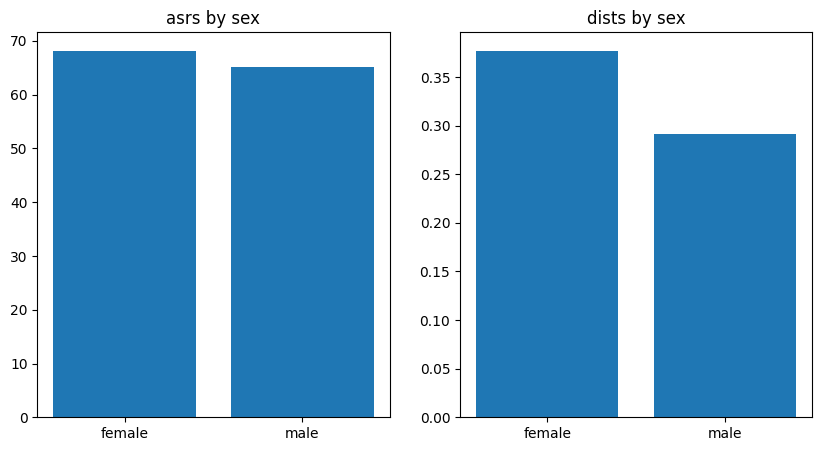

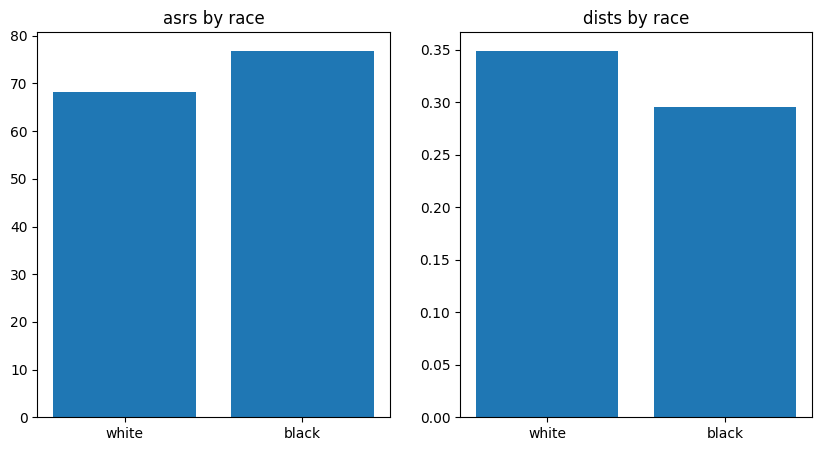

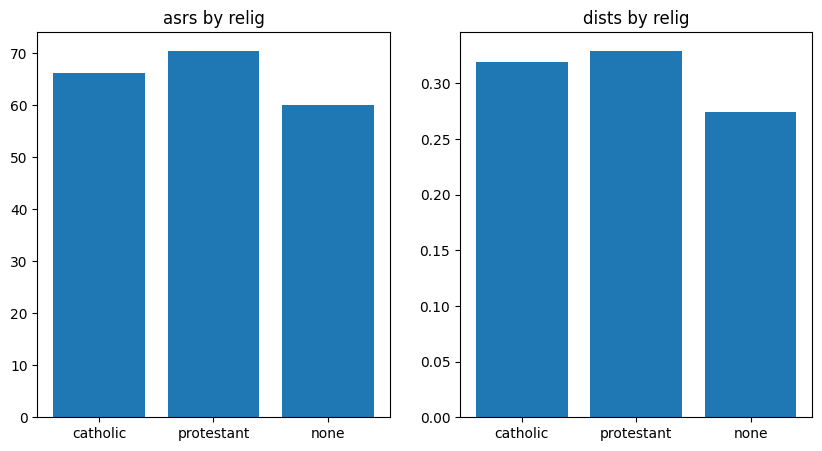

In [23]:
subgroup_columns = ['sex', 'race', 'relig']

# if 'att_enc' not in globals():
#     y_onehot, att_enc = model_utils.get_onehot(y.to_numpy().ravel().reshape(-1,1))
test_size = 0.5

x_n_tr, x_n_te, y_n_tr, y_n_te= train_test_split(X_neuron, y, test_size=test_size, random_state=42)
subgroup_disparity_dict = get_subgroup_disparity_baseline(ds, subgroup_columns, x_n_te, y_n_te, metric='auc')
print(subgroup_disparity_dict)
plot_subgroup_disparity(subgroup_disparity_dict)

In [ ]:
test_indices = np.arange(len(X_neuron))[np.isin(X_neuron, x_n_te)]

## Our attack with random data

In [ ]:
random_df = filter_random_data(ds, clf, num_samples=1000000)
X_random_neuron = make_neuron_output_data(random_df, clf, y_columns)
y_random = random_df[ds.ds.meta['sensitive_column'] + "_" + ds.ds.meta['sensitive_positive']]

In [ ]:
random_neuron_clf = model_utils.get_model(max_iter=500)
y_random_onehot = att_enc.transform(y_random.to_numpy().ravel().reshape(-1,1))
random_neuron_clf.fit(X_random_neuron, y_random_onehot)

In [ ]:
# test on the test data
acc = 100 * random_neuron_clf.score(x_n_te, att_enc.transform(y_n_te.to_numpy().ravel().reshape(-1,1)))
if True:
    print(f"Attack accuracy: {acc}")

In [ ]:
t1 = torch.from_numpy(X_train.iloc[0].to_numpy()).float().to(model_utils.device)
# out_1 = torch.relu(np.matmul(X_train.iloc[0].to_numpy(), clf.coefs_[0]) + clf.intercepts_[0])
out_1 = torch.relu(torch.matmul(t1, torch.from_numpy(clf.coefs_[0]).float().to(model_utils.device)) + torch.from_numpy(clf.intercepts_[0]).float().to(model_utils.device))
print(out_1)
out_2 = (np.matmul(out_1, clf.coefs_[1]) + clf.intercepts_[1])
print(out_2)